In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith

In [ ]:
import getpass
import os
from dotenv import load_dotenv
# Load environment variables
import openai
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langchain_core.messages import AIMessage, ToolMessage

from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import operator
import os
import csv
import openai
import re
import networkx as nx
from typing import Annotated, Any, List, Dict, Optional
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver
#from app.config import Config
load_dotenv()

# Set up OpenAI API key
openai.api_key = os.getenv('OPENAI_API_KEY')



In [ ]:
# Set up OpenAI API key
openai.api_key = os.getenv('OPENAI_API_KEY')  # Ensure your API key is set as an environment variable

# Define the state schema with scripts and table_info fields
# Define the state schema with scripts and table_info fields
class State(TypedDict):
    scripts: Annotated[List[str], operator.add]
    table_info: Annotated[List[dict], operator.add]
    execution_order: List[str]
    # For HITL
    error_messages: Annotated[List[str], operator.add]
    ask_human: bool
    messages: Annotated[List[Any], operator.add]  # For GPT messages and human interaction
    known_tables: Annotated[List[str], operator.add]  # Add known_tables to state


# Function to be executed by each parallel node
class ParallelNode:
    def __init__(self, base_name: str, file_list: List[str], folder_path: str):
        self.base_name = base_name
        self.file_list = file_list  # List of CSV files to process
        self.folder_path = folder_path

    def __call__(self, state: State) -> Any:
        try:
            # Read CSV files and collect data
            all_rows = []
            headers = []
            for filename in self.file_list:
                file_path = os.path.join(self.folder_path, filename)
                with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
                    reader = csv.DictReader(csvfile)
                    headers = reader.fieldnames
                    rows = list(reader)
                    all_rows.extend(rows)
            if not all_rows:
                error_message = f"No data found in files for table '{self.base_name}'"
                print(error_message)
                # Set flag to ask for human assistance
                return {
                    "error_messages": [error_message],
                    "ask_human": True,
                    "messages": [error_message],
                }
            # Derive data types from sample data
            column_types = self.derive_column_types(all_rows)
            # List of known table names from state
            known_tables = state.get('known_tables', []).copy()  # Use copy to avoid modifying shared state
            known_tables.append(self.base_name)
            # Prepare prompt for GPT-4
            prompt = self.prepare_prompt(column_types, all_rows, known_tables)
            # Call GPT-4 to generate SQL script
            script = self.call_gpt4(prompt)
            # Extract primary and foreign keys from the script
            table_info = self.extract_keys(script, known_tables)
            table_info['table_name'] = self.base_name
            print(f"Node processing table '{self.base_name}' generated script.")
            # Update the known tables in state
            return {
                "scripts": [script],
                "table_info": [table_info],
                # Return the updated known_tables
                "known_tables": [self.base_name],  # Return only the new table to be added
            }
        except Exception as e:
            # Handle exceptions and set flag to ask for human assistance
            error_message = f"Error in node '{self.base_name}': {str(e)}"
            print(error_message)
            return {
                "error_messages": [error_message],
                "messages": [error_message],
            }

    def derive_column_types(self, rows: List[Dict[str, str]]) -> Dict[str, str]:
        # Simple data type inference from sample data
        column_types = {}
        sample_rows = rows[:10]  # Use first 10 rows for inference
        for column in rows[0].keys():
            types = set()
            for row in sample_rows:
                value = row[column]
                if value.isdigit():
                    types.add('INTEGER')
                else:
                    try:
                        float(value)
                        types.add('FLOAT')
                    except ValueError:
                        types.add('TEXT')
            # Prioritize types
            if 'TEXT' in types:
                column_types[column] = 'TEXT'
            elif 'FLOAT' in types:
                column_types[column] = 'FLOAT'
            else:
                column_types[column] = 'INTEGER'
        return column_types

    def prepare_prompt(self, column_types: Dict[str, str], rows: List[Dict[str, str]], known_tables: List[str]) -> str:
        # Prepare sample data
        headers = list(column_types.keys())
        sample_rows = [list(row.values()) for row in rows[:2]]  # Use first 2 rows
        # Construct the prompt
        prompt = (
            f"Given the following table definition and sample data, "
            f"generate a SQL CREATE TABLE script for a table named '{self.base_name}'. "
            f"Include appropriate data types, primary keys, and foreign keys if applicable. "
            f"Do not reference tables other than '{', '.join(known_tables)}'.\n\n"
            f"Columns and data types:\n"
        )
        for col, dtype in column_types.items():
            prompt += f"- {col}: {dtype}\n"
        prompt += "\nSample data:\n"
        prompt += ', '.join(headers) + '\n'
        for row in sample_rows:
            prompt += ', '.join(row) + '\n'
        prompt += "\nPlease provide the SQL script. Start without ```sql"
        return prompt


    def call_gpt4(self, prompt: str) -> str:
        llm = ChatOpenAI(model='gpt-3.5-turbo',max_tokens=500, temperature=0.0, n=1, stop=None)
        # Call the OpenAI GPT-4 model
        messages=[{"role": "system", "content": "You are an expert SQL database designer."},
                {"role": "user", "content": prompt}]
        script = llm.invoke(messages)
        #script = response.choices[0].message.content.strip()
        return script.content

    def extract_keys(self, script: str, known_tables: List[str]) -> Dict[str, List[str]]:
        # Simple parsing of SQL script to extract primary and foreign keys
        primary_keys = []
        foreign_keys = []
        # Use regex to find PRIMARY KEY and FOREIGN KEY constraints
        pk_match = re.search(r'PRIMARY KEY\s*\((.*?)\)', script, re.IGNORECASE | re.DOTALL)
        if pk_match:
            pk_fields = pk_match.group(1)
            primary_keys = [field.strip(' `') for field in pk_fields.split(',')]
        fk_matches = re.findall(
            r'FOREIGN KEY\s*\((.*?)\)\s*REFERENCES\s*`?(\w+)`?\s*\((.*?)\)',
            script, re.IGNORECASE | re.DOTALL
        )
        for fk_field, ref_table, ref_field in fk_matches:
            if ref_table in known_tables:
                foreign_keys.append(ref_table)
            else:
                print(f"Warning: Foreign key references unknown table '{ref_table}'. Ignoring.")
        return {'primary_keys': primary_keys, 'foreign_keys': foreign_keys}


# Supervisor function to determine execution order based on dependencies
def supervisor(state: State) -> Any:
    table_infos = state.get("table_info", [])
    scripts = state.get("scripts", [])
    known_tables = [info['table_name'] for info in table_infos]
    # Build a dependency graph
    G = nx.DiGraph()
    for info in table_infos:
        G.add_node(info['table_name'])
    for info in table_infos:
        for fk in info['foreign_keys']:
            if fk in known_tables:
                G.add_edge(fk, info['table_name'])
            else:
                print(f"Warning: Foreign key references unknown table '{fk}'. Ignoring edge.")
    # Perform topological sort
    try:
        execution_order = list(nx.topological_sort(G))
        print("Determined execution order:", execution_order)
    except nx.NetworkXUnfeasible:
        error_message = "Error: Cyclic dependency detected in foreign keys."
        print(error_message)
        return {
            "error_messages": [error_message],
            "ask_human": True,
            "messages": [error_message],
        }
    # Map table names to scripts
    table_name_to_script = {info['table_name']: script for info, script in zip(table_infos, scripts)}
    # Ordered list of scripts
    ordered_scripts = [table_name_to_script[table_name] for table_name in execution_order]
    return {"execution_order": ordered_scripts}


# Final node to execute scripts in the determined order
def final_node(state: State) -> Any:
    print("Executing scripts in the following order:")
    for script in state["execution_order"]:
        print(script)
        # Here you would execute the script on the database
    return state

# Human-in-the-Loop node
def human_node(state: State) -> Any:
    error_messages = state.get("error_messages", [])
    print("Human intervention required.")
    for message in error_messages:
        print(f"Error: {message}")
    # Here, implement logic to allow human to resolve the issue
    # For example, fix the data, modify the prompt, or provide a corrected script
    # For the purpose of this example, we'll simulate human resolution
    resolved = False
    # Simulate human resolving the issue
    # In practice, you might read input from a human operator or perform some manual steps
    print("Simulating human resolution...")
    resolved = True  # Assume the issue is resolved
    if resolved:
        # Reset error messages and flags
        return {
            "error_messages": [],
            "ask_human": False,
            # You might update scripts or table_info here based on human input
        }
    else:
        # If not resolved, you might terminate or take other actions
        return {
            "ask_human": True,
        }

# Function to select the next node based on state
def select_next_node(state: State) -> str:
    if state.get("ask_human", False):
        return "human"
    else:
        return None  # Continue to the next node in the graph

# Function to group CSV files by base name
def group_csv_files(folder_path: str) -> Dict[str, List[str]]:
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    groups = {}
    for filename in csv_files:
        # Extract base name; e.g., for 'bse_1.csv' or 'bse_2.csv', base name is 'bse'
        base_name = filename.split('_')[0]
        if base_name not in groups:
            groups[base_name] = []
        groups[base_name].append(filename)
    return groups

# Initialize the graph
builder = StateGraph(State)

# Add the initial node
builder.add_node("initial", lambda state: state)
builder.add_edge(START, "initial")

# Provide the folder path
folder_path = '/Users/philipnartschik/Downloads/Demo'  # Replace with your actual folder path

# Group CSV files by base name
csv_groups = group_csv_files(folder_path)

# Dynamically add parallel nodes based on the number of base names
for base_name, file_list in csv_groups.items():
    node_name = f"parallel_{base_name}"
    builder.add_node(node_name, ParallelNode(base_name, file_list, folder_path))
    builder.add_edge("initial", node_name)
    # Add conditional edge to check for errors and possibly go to human node
    builder.add_conditional_edges(
        node_name,
        select_next_node,
        {"human": "human", None: "supervisor"},
    )

# Add the supervisor node
builder.add_node("supervisor", supervisor)

# Connect parallel nodes to the supervisor node
for base_name in csv_groups.keys():
    node_name = f"parallel_{base_name}"
    # Edge to supervisor if no errors
    builder.add_edge(node_name, "supervisor")

# Add the human node
builder.add_node("human", human_node)
# After human intervention, return to the supervisor or reprocess the node
builder.add_edge("human", "supervisor")

# Add the final node
builder.add_node("final", final_node)
builder.add_edge("supervisor", "final")
builder.add_edge("final", END)

# Compile the graph
memory = MemorySaver()
graph = builder.compile(
#    checkpointer=memory,
    interrupt_before=["human"],
)

# Execute the graph with the initial state
initial_state = {
    "scripts": [],
    "table_info": [],
    "execution_order": [],
    "error_messages": [],
    "ask_human": False,
    "messages": [],
    "known_tables": [],
}
graph.invoke(initial_state)



Node processing table 'T16FG' generated script.
Node processing table 'T024' generated script.
Node processing table 'T161T' generated script.
Node processing table 'LFA1' generated script.
Node processing table 'T163I' generated script.
Node processing table 'DD03L' generated script.
Node processing table 'QAVE' generated script.
Node processing table 'TCURR' generated script.
Node processing table 'DD07T' generated script.Node processing table 'EKES' generated script.

Node processing table 'T001' generated script.
Node processing table 'T16FB' generated script.
Node processing table 'EKET' generated script.
Error in node 'MAKT': 'list' object has no attribute 'isdigit'Node processing table 'NAST' generated script.

Node processing table 'LIPS' generated script.
Node processing table 'CDPOS' generated script.
Node processing table 'QAMR' generated script.
Node processing table 'CDHDR' generated script.Node processing table 'DDFTX' generated script.

Node processing table 'ESSR' gener

{'scripts': ['```sql\nCREATE TABLE BSEG (\n    AUGBL VARCHAR(255),\n    AUGCP VARCHAR(255),\n    AUGDT VARCHAR(255),\n    AUGGJ INT,\n    BELNR VARCHAR(255),\n    BSCHL INT,\n    BUKRS INT,\n    BUZEI VARCHAR(255),\n    BUZID VARCHAR(255),\n    DMBTR DECIMAL(18, 2),\n    GJAHR INT,\n    KOART VARCHAR(1),\n    KUNNR VARCHAR(255),\n    LIFNR VARCHAR(255),\n    MABER VARCHAR(255),\n    MADAT VARCHAR(255),\n    MANDT VARCHAR(255),\n    MANSP INT,\n    MANST INT,\n    MENGE DECIMAL(18, 3),\n    MSCHL VARCHAR(255),\n    MWSKZ VARCHAR(255),\n    NETDT VARCHAR(255),\n    PRCTR VARCHAR(255),\n    PSWBT DECIMAL(18, 2),\n    REBZG INT,\n    REBZJ INT,\n    REBZZ INT,\n    SAKNR VARCHAR(255),\n    SGTXT VARCHAR(255),\n    SHKZG VARCHAR(1),\n    SK1DT VARCHAR(255),\n    SK2DT VARCHAR(255),\n    SKFBT DECIMAL(18, 2),\n    SKNTO DECIMAL(18, 2),\n    WRBTR DECIMAL(18, 2),\n    WSKTO DECIMAL(18, 2),\n    ZBD1P DECIMAL(18, 2),\n    ZBD1T VARCHAR(255),\n    ZBD2P DECIMAL(18, 2),\n    ZBD2T VARCHAR(255),\

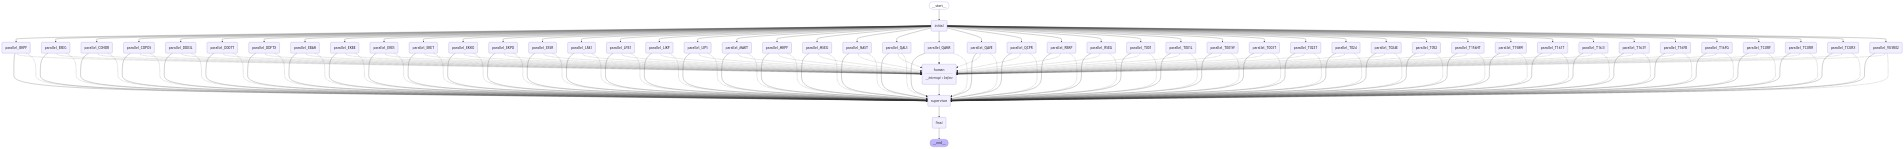

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

config = {"configurable": {"thread_id": "1"}}